In [1]:
import numpy as np
from scipy import sparse
from scipy.linalg import cholesky, solve_triangular
from scipy.io import loadmat
import time
import matplotlib.pyplot as plt

##### Define GP kernel functions

In [2]:
def cov_matern(d, loghyper, x):
    ell = np.exp(loghyper[0])
    sf2 = np.exp(2 * loghyper[1])    
    def f(t):
        if d == 1: return 1
        if d == 3: return 1 + t
        if d == 5: return 1 + t * (1 + t / 3)
        if d == 7: return 1 + t * (1 + t * (6 + t) / 15)       
    def m(t):
        return f(t) * np.exp(-t)   
    dist_sq = ((x[:, None] - x[None, :]) / ell) ** 2
    return sf2 * m(np.sqrt(d * dist_sq))

def RL_precision(logbeta, A):
    beta = np.exp(logbeta)    
    A = np.asarray(A, dtype=float)
    n = A.shape[0]
    A = A - np.eye(n)
    iD = np.diag(1 / np.sqrt(A.sum(axis=0))) 
    Lap = np.eye(n) - iD @ A @ iD    
    return np.eye(n) + beta * Lap

##### Sample kernel hyperparameters from the marginal posterior using slice sampling

In [3]:
def compute_factor_term(G, mask, Y, dim):
    Psi = sparse.kron(G, sparse.eye(dim, format="csr"), format="csr")
    mask_vec = (np.asarray(mask).ravel(order="F") == 1)
    rows = np.flatnonzero(mask_vec)
    Psi_mask = Psi[rows, :]
    HH = Psi_mask.T @ Psi_mask
    y_obs = np.asarray(Y).ravel(order="F")[mask_vec].reshape(-1, 1)
    Hy = Psi_mask.T @ y_obs
    return HH, Hy

def compute_likeli_term(invK, R, tau, HH, Hy):
    invSigma = sparse.kron(sparse.eye(R, format="csr"), invK, format="csr")
    Lambda = (tau * HH + invSigma).toarray()
    cholL = cholesky(Lambda)
    uu = solve_triangular(cholL.T, Hy, lower=True)
    likeli_temp = 0.5 * (tau ** 2) * (uu.T @ uu).item() - np.sum(np.log(np.diag(cholL)))
    return invSigma, cholL, likeli_temp

def compute_likeli_KU(tau, invKu, HHU, HyU, R):
    invKU, cholLU, likeli_temp = compute_likeli_term(invKu, R, tau, HHU, HyU)
    cholLu = cholesky(invKu)
    likeli_KU = likeli_temp + R * np.sum(np.log(np.diag(cholLu)))
    return cholLu, invKU, cholLU, likeli_KU

def compute_likeli_KV(tau, Kv, HHV, HyV, R):
    eigvalKv, Qvt = np.linalg.eigh(Kv)
    invKv = Qvt @ np.diag(1.0 / eigvalKv) @ Qvt.T
    invKV, cholLV, likeli_temp = compute_likeli_term(invKv, R, tau, HHV, HyV)
    likeli_KV = likeli_temp + 0.5 * R * np.sum(np.log(eigvalKv))
    return eigvalKv, invKV, cholLV, likeli_KV

def prior_theta(hpri, theta):
    mu, lamb = hpri
    return -0.5 * lamb * (theta-mu) ** 2

def theta_range(ranges, theta, min_hp, max_hp):
    tempt = ranges * np.random.rand()
    tmin = max(theta - tempt, min_hp)
    tmax = min(tmin + ranges, max_hp)
    return tmin, tmax

def hyperU_RL_marginal(theta_est, ranges, likeli, tau, HHU, HyU, min_hp, max_hp, hpri, A, R):
    PU = likeli + prior_theta(hpri, theta_est)  
    tmin, tmax = theta_range(ranges, theta_est, min_hp, max_hp)
    logu = np.log(np.random.rand())
    while True:
        theta_next = tmin + (tmax - tmin) * np.random.rand()
        invKu_next = RL_precision(theta_next, A)        
        cholLu, invKU_next, cholLU, likeli_next = compute_likeli_KU(tau, invKu_next, HHU, HyU, R)
        PU_next = likeli_next + prior_theta(hpri, theta_next)
        if PU_next - PU > logu:
            return theta_next, invKU_next, cholLU, cholLu, likeli_next
        elif theta_next < theta_est:
            tmin = theta_next
        else:
            tmax = theta_next

def hyperV_Matern_marginal(theta_est, ranges, likeli, tau, HHV, HyV, min_hp, max_hp, hpri, d_Matern, matern_var, T, R):    
    PV = likeli + prior_theta(hpri, theta_est)
    tmin, tmax = theta_range(ranges, theta_est, min_hp, max_hp)
    logu = np.log(np.random.rand())
    while True:
        theta_next = tmin + (tmax - tmin) * np.random.rand()
        Kv_next = cov_matern(d_Matern, [theta_next, np.log(matern_var)], np.arange(1, T + 1))
        eigvalKv, invKV_next, cholLV, likeli_next = compute_likeli_KV(tau, Kv_next, HHV, HyV, R)
        PV_next = likeli_next + prior_theta(hpri, theta_next)
        if PV_next - PV > logu:
            return theta_next, invKV_next, cholLV, eigvalKv, likeli_next
        elif theta_next < theta_est:
            tmin = theta_next
        else:
            tmax = theta_next

##### Draw latent factors from conditional posterior distribution (Gibbs updates)

In [4]:
def mvnrnd_pre_ch(mean, chol_prec):
    z = np.random.randn(mean.shape[0], 1)
    return mean + solve_triangular(chol_prec, z, lower=False)

def sample_factor(tau, cholL, Hy, N):
    tmp = solve_triangular(cholL.T, Hy, lower=True)
    Mean = tau * solve_triangular(cholL, tmp, lower=False)
    temp_vec = mvnrnd_pre_ch(Mean, cholL)
    return temp_vec.reshape((N[0], N[1]), order="F")

##### Draw observation noise precision (Gibbs update)

In [5]:
def sample_tau(Y, Y_est, mask_matrix, num_obser, a0, b0):
    Err = np.linalg.norm((Y - Y_est) * mask_matrix, ord='fro')**2
    a_tau = a0 + 0.5 * num_obser
    b_tau = b0 + 0.5 * Err
    return np.random.gamma(shape=a_tau, scale=1.0 / b_tau)

##### Compute error metrics

In [6]:
def compute_mae(Y, Y_est, mask_test):
    return np.sum(np.abs(Y_est - Y) * mask_test) / np.sum(mask_test)

def compute_rmse(Y, Y_est, mask_test):
    return np.sqrt((np.linalg.norm((Y - Y_est) * mask_test, ord="fro")**2) / np.sum(mask_test == 1))

##### BKMF implementation

In [7]:
def BKMF(I, A, Omega, mask_test, U_gra_scale, V_matern_scale, V_matern_var, ranges, min_hp, max_hp, hpri, d_Matern, a0, b0, tau0, R, burn_iter, pos_iter, start):
    N = np.array(I.shape)
    D = I.ndim
    num_obser = np.sum(Omega)
    mask_matrix = [Omega, Omega.T]
    
    train_matrix = I * Omega
    train_matrix = train_matrix[train_matrix > 0]
    Isubmean = I - np.mean(train_matrix)
    I_train = Isubmean * Omega
    Y_train = [I_train, I_train.T]
    
    G = [0.1 * np.random.randn(N[d], R) for d in range(D)]
    
    max_iter = burn_iter + pos_iter
    mae = np.zeros(max_iter)
    rmse = np.zeros(max_iter)
    G_save = [np.zeros((N[d], R, pos_iter)) for d in range(D)]
    hyper_K = np.zeros((max_iter + 1, D))
    
    hyper_K[0, 0] = np.log(U_gra_scale)
    hyper_K[0, 1] = np.log(V_matern_scale)
    invKu = RL_precision(hyper_K[0, 0], A)
    Kv = cov_matern(d_Matern, [hyper_K[0, 1], np.log(V_matern_var)], np.arange(1, N[1] + 1))
    
    HH = [None] * D
    Hy = [None] * D
    for d in range(D):
        HH[d], Hy[d] = compute_factor_term(G[1-d], mask_matrix[d], Y_train[d], N[d])
    
    tau = np.zeros(max_iter + 1)
    tau[0] = tau0
    cholLu, invKU, cholLU, likeli_KU = compute_likeli_KU(tau[0], invKu, HH[0], Hy[0], R)
    eigvalKv, invKV, cholLV, likeli_KV = compute_likeli_KV(tau[0], Kv, HH[1], Hy[1], R)
    
    Y_est_sum = 0
    Y_est_sum2 = 0
    for it in range(burn_iter + pos_iter):
        hyper_K[it+1, 0], invKU, cholLU, cholLu, likeli_KU = hyperU_RL_marginal(
            hyper_K[it, 0], ranges[0], likeli_KU, tau[it], HH[0], Hy[0], min_hp[0], max_hp[0], hpri[0], A, R)
        
        G[0] = sample_factor(tau[it], cholLU, Hy[0], G[0].shape)

        hyper_K[it+1, 1], invKV, cholLV, eigvalKv, likeli_KV = hyperV_Matern_marginal(
            hyper_K[it, 1], ranges[1], likeli_KV, tau[it], HH[1], Hy[1], min_hp[1], max_hp[1], hpri[1], d_Matern, V_matern_var, N[1], R)
        
        HH[1], Hy[1] = compute_factor_term(G[0], mask_matrix[1], Y_train[1], N[1])
        LambdaV = (tau[it] * HH[1] + invKV).toarray()
        cholLV = cholesky(LambdaV)
        G[1] = sample_factor(tau[it], cholLV, Hy[1], G[1].shape)
        
        Y_est = G[0] @ G[1].T
        
        tau[it + 1] = sample_tau(Isubmean, Y_est, mask_matrix[0], num_obser, a0, b0)
        
        if it >= burn_iter:
            st_it = it - burn_iter
            for d in range(D):
                G_save[d][:, :, st_it] = G[d]
            Y_est_sum2 = Y_est_sum2 + Y_est

        Y_est_sum = Y_est_sum + Y_est
        Y_est_ave = Y_est_sum/(it + 1)
        mae[it] = compute_mae(Isubmean, Y_est_ave, mask_test)
        rmse[it] = compute_rmse(Isubmean, Y_est_ave, mask_test)
        print(f"Epoch = {it + 1}, tau = {tau[it + 1]}, mae = {mae[it]}, rmse = {rmse[it]}")
        end = time.time()
        print('Running time: %d seconds'%(end - start))
        
        HH[0], Hy[0] = compute_factor_term(G[1], mask_matrix[0], Y_train[0], N[0])
        LambdaU = (tau[it + 1] * HH[0] + invKU).toarray()
        cholLU = cholesky(LambdaU)
        uu = solve_triangular(cholLU.T, Hy[0], lower=True)
        likeli_KU = 0.5 * (tau[it + 1] ** 2) * (uu.T @ uu).item() - np.sum(np.log(np.diag(cholLU))) + R * np.sum(np.log(np.diag(cholLu)))
        
        LambdaV = (tau[it + 1] * HH[1] + invKV).toarray()
        cholLV = cholesky(LambdaV)
        uu = solve_triangular(cholLV.T, Hy[1], lower=True)
        likeli_KV = 0.5 * (tau[it + 1] ** 2) * (uu.T @ uu).item() - np.sum(np.log(np.diag(cholLV))) + 0.5 * R * np.sum(np.log(eigvalKv))
        
    return G, G_save, hyper_K, tau, mae, rmse, Y_est_sum2/pos_iter + np.mean(train_matrix)

##### Run BKMF

In [8]:
def generate_missing_RM(missing_rate, N, Omega_raw):
    mask_matrix = (np.round(np.random.rand(N[0], N[1]) + 0.5 - missing_rate)).astype(np.int8)
    mask_matrix = mask_matrix & Omega_raw
    mask_test = (1 - mask_matrix) & Omega_raw
    return mask_matrix, mask_test

def run_BKMF(I, A, missing_rate, U_gra_scale, V_matern_scale, V_matern_var, ranges, min_hp, max_hp, hpri, d_Matern, a0, b0, tau0, R, burn_iter, pos_iter):
    N = I.shape
    Omega_raw = (I != 0).astype(np.int8)
    mask_matrix, mask_test = generate_missing_RM(missing_rate, N, Omega_raw)
    start = time.time()
    G, G_save, hyper_K, tau, mae, rmse, Y_est_ = BKMF(
        I, A, mask_matrix, mask_test, U_gra_scale, V_matern_scale, V_matern_var, ranges, min_hp, max_hp, hpri, d_Matern, a0, b0, tau0, R, burn_iter, pos_iter, start)
    return G, G_save, hyper_K, tau, mae, rmse, Y_est_, mask_matrix, mask_test

##### Define pre-specified parameters

In [9]:
# specified parameters
U_gra_scale = 1
V_matern_scale = 1
V_matern_var = 1
ranges = [np.log(10), np.log(10)]
min_hp = [np.log(1e-3), np.log(1e-6)]
max_hp = [np.log(1e3), np.log(1e6)]
hpri = [None] * 2
hpri[0] = [np.log(10), 1]
hpri[1] = [np.log(10), 1]
d_Matern = 3
a0 = 1e-6
b0 = 1e-6
tau0 = 1e-2
R = 10
burn_iter = 200
pos_iter = 100

##### Test on Seattle traffic speed data

In [10]:
"""Test BKMF on Seattle traffic speed; data size: 323 locations × 720 time points (24 hours × 30 days; one time point per hour)"""
seedr = 6
np.random.seed(seedr)
A = loadmat('../data/traffic/seattle/seattle_adj.mat')['A']
I = loadmat('../data/traffic/seattle/sedata_amonth_matrix.mat')['data_matrix']
missing_rate = 0.5 # 50% random missing (RM)
G, G_save, hyper_K, tau, mae, rmse, Y_est_, mask_matrix, mask_test = run_BKMF(
    I, A, missing_rate, U_gra_scale, V_matern_scale, V_matern_var, ranges, min_hp, max_hp, hpri, d_Matern, a0, b0, tau0, R, burn_iter, pos_iter)

Epoch = 1, tau = 0.009435092208665324, mae = 6.958165869307865, rmse = 10.532178348664454
Running time: 6 seconds
Epoch = 2, tau = 0.03697253450907345, mae = 4.724518048734913, rmse = 7.233102672437235
Running time: 10 seconds
Epoch = 3, tau = 0.061238137667688874, mae = 3.7642993441999115, rmse = 5.862934917888954
Running time: 20 seconds
Epoch = 4, tau = 0.07854780648205008, mae = 3.233695847292867, rmse = 5.131752695502853
Running time: 28 seconds
Epoch = 5, tau = 0.08411316643301457, mae = 2.9249727707802995, rmse = 4.715249992726064
Running time: 39 seconds
Epoch = 6, tau = 0.08495959491465052, mae = 2.7331392112190556, rmse = 4.463992360694567
Running time: 66 seconds
Epoch = 7, tau = 0.0855226961983531, mae = 2.6067114516991565, rmse = 4.3021346015698585
Running time: 86 seconds
Epoch = 8, tau = 0.08597812015538112, mae = 2.519494113607131, rmse = 4.1923807575375855
Running time: 106 seconds
Epoch = 9, tau = 0.08596585525205773, mae = 2.456730924097143, rmse = 4.1149016269095595

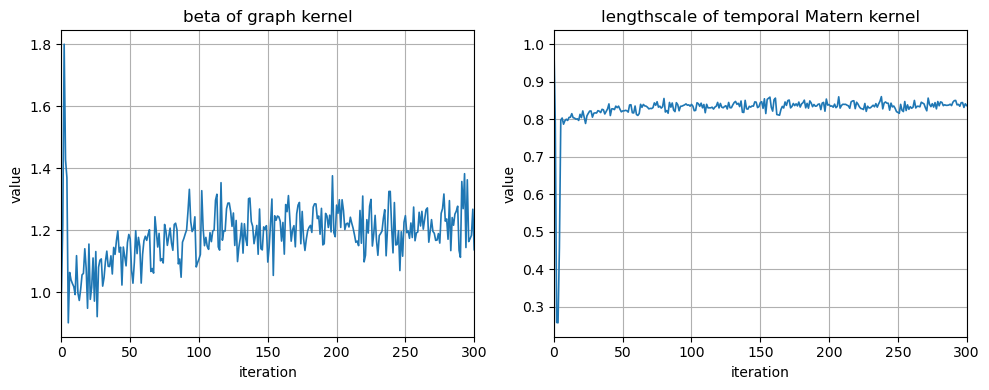

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)

axes[0].plot(np.exp(hyper_K[:, 0]), linewidth=1.2)
axes[0].set_title("beta of graph kernel")
axes[0].grid(True)
axes[0].set_xlabel("iteration")
axes[0].set_ylabel("value")
axes[0].set_xlim(0, len(hyper_K[:, 0]) - 1)

axes[1].plot(np.exp(hyper_K[:, 1]), linewidth=1.2)
axes[1].set_title("lengthscale of temporal Matern kernel")
axes[1].grid(True)
axes[1].set_xlabel("iteration")
axes[1].set_ylabel("value")
axes[1].set_xlim(0, len(hyper_K[:, 1]) - 1)

plt.show()

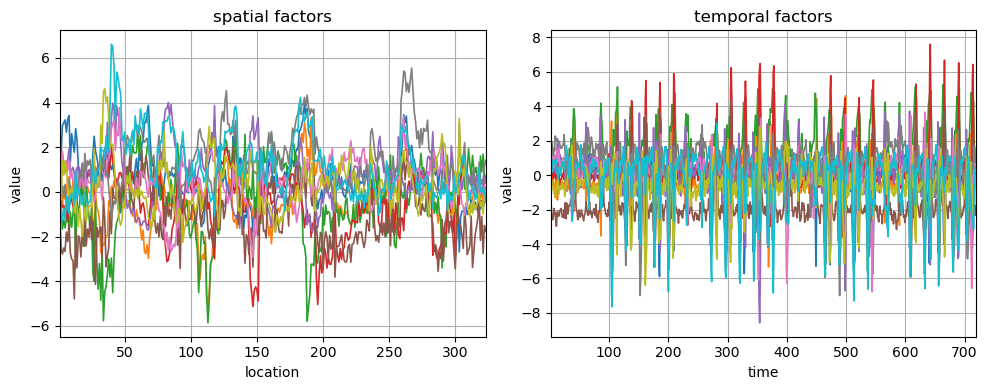

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)
N = I.shape
x = np.arange(1, N[0] + 1)
axes[0].plot(x, G[0], linewidth=1.2)
axes[0].set_title("spatial factors")
axes[0].grid(True)
axes[0].set_xlabel("location")
axes[0].set_ylabel("value")
axes[0].set_xlim(1, len(x))

x = np.arange(1, N[1] + 1)
axes[1].plot(x, G[1], linewidth=1.2)
axes[1].set_title("temporal factors")
axes[1].grid(True)
axes[1].set_xlabel("time")
axes[1].set_ylabel("value")
axes[1].set_xlim(1, len(x))

plt.show()

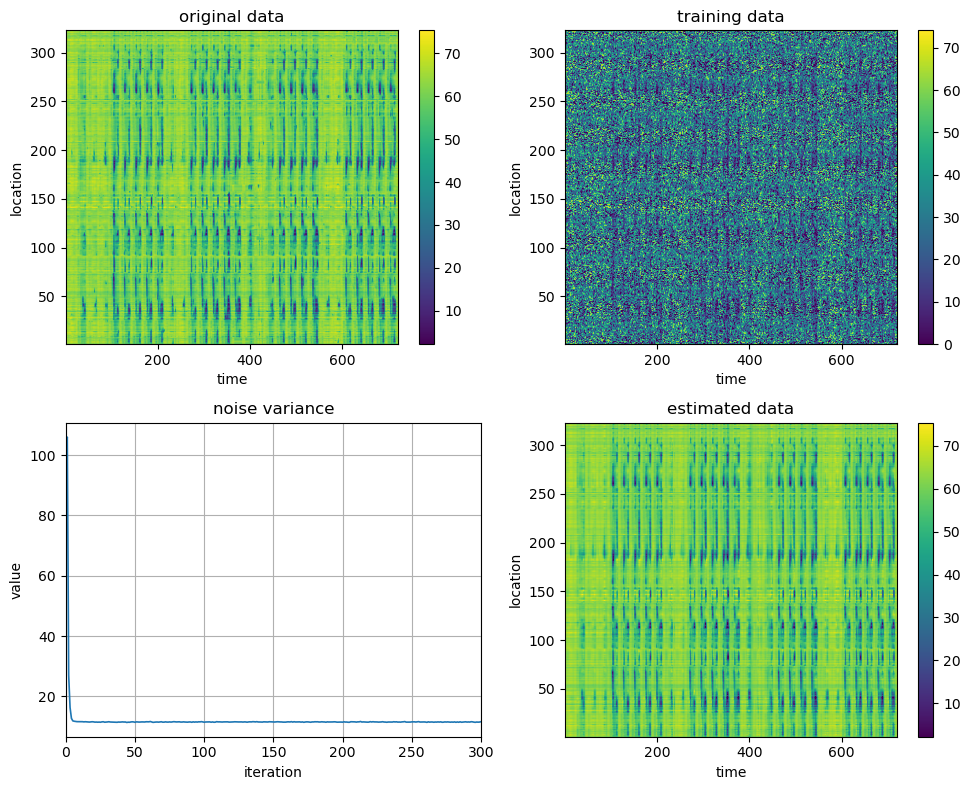

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8), tight_layout=True)

# x = np.arange(1, N[1] + 1)
# axes[0,0].plot(x, I.T, linewidth=1)
# axes[0,0].set_title("original data")
# axes[0,0].grid(True)
# axes[0,0].set_xlabel("time")
# axes[0,0].set_ylabel("value")
# axes[0,0].set_xlim(1, len(x))
im = axes[0,0].imshow(I, aspect="auto", origin="lower", extent=[1,N[1], 1,N[0]])
axes[0,0].set_title("original data")
axes[0,0].set_xlabel("time")
axes[0,0].set_ylabel("location")
fig.colorbar(im, ax=axes[0,0])
vmin, vmax = im.get_clim()

im = axes[0,1].imshow(I * mask_matrix, aspect="auto", origin="lower", extent=[1,N[1], 1,N[0]])
axes[0,1].set_title("training data")
axes[0,1].set_xlabel("time")
axes[0,1].set_ylabel("location")
fig.colorbar(im, ax=axes[0,1])

axes[1,0].plot(1.0 / tau, linewidth=1.2)
axes[1,0].set_title("noise variance")
axes[1,0].grid(True)
axes[1,0].set_xlabel("iteration")
axes[1,0].set_ylabel("value")
axes[1,0].set_xlim(0, len(tau) - 1)

# axes[1,1].plot(x, Y_est_.T, linewidth=1)
# axes[1,1].set_title("estimated data")
# axes[1,1].grid(True)
# axes[1,1].set_xlabel("time")
# axes[1,1].set_ylabel("value")
# axes[1,1].set_xlim(1, len(x))
im = axes[1,1].imshow(Y_est_, aspect="auto", origin="lower", extent=[1,N[1], 1,N[0]], vmin=vmin, vmax=vmax)
axes[1,1].set_title("estimated data")
axes[1,1].set_xlabel("time")
axes[1,1].set_ylabel("location")
fig.colorbar(im, ax=axes[1,1])

plt.show()

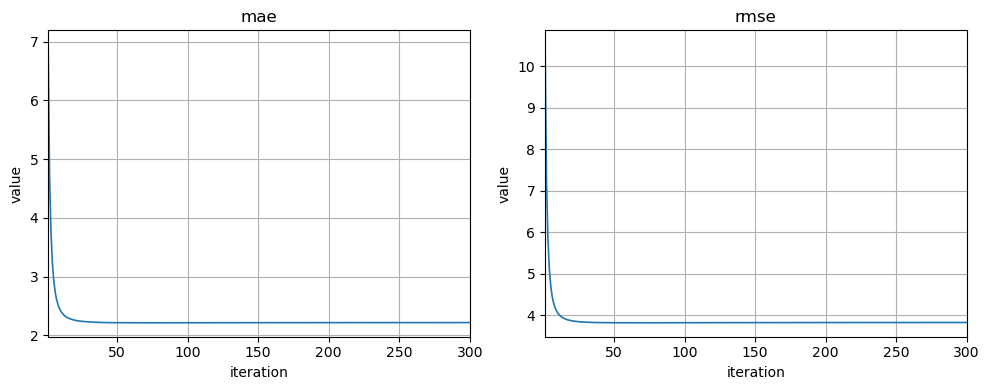

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)
x = np.arange(1, len(mae) + 1)
axes[0].plot(x, mae, linewidth=1.2)
axes[0].set_title("mae")
axes[0].grid(True)
axes[0].set_xlabel("iteration")
axes[0].set_ylabel("value")
axes[0].set_xlim(1, len(x))

axes[1].plot(x, rmse, linewidth=1.2)
axes[1].set_title("rmse")
axes[1].grid(True)
axes[1].set_xlabel("iteration")
axes[1].set_ylabel("value")
axes[1].set_xlim(1, len(x))

plt.show()